# mmcls训练

## 1. 确认torch是否能够正常使用cuda环境

In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

/home/hanhan/anaconda3/envs/mmpose/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


1.10.0+cu111
True


## 2. 从源码配置安装

In [ ]:

!git clone https://github.com/open-mmlab/mmpretrain.git
!cd mmpretrain
# !pip install -U openmim && mim install -e .


###

In [3]:
# !python demo/image_demo.py demo/demo.JPEG resnet18_8xb32_in1k --device cpu

import mmpretrain
from mmpretrain import get_model, list_models, inference_model

list_models(task='Image Caption', pattern='blip')
inference_model('blip-base_3rdparty_caption', 'demo/cat-dog.png',show=True) 

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'BertTokenizer'. 
The class this function is called from is 'BlipTokenizer'.


Loads checkpoint by http backend from path: https://download.openmmlab.com/mmclassification/v1/blip/blip-base_3rdparty_coco-caption_20230419-a5b71af3.pth


Downloading: "https://download.openmmlab.com/mmclassification/v1/blip/blip-base_3rdparty_coco-caption_20230419-a5b71af3.pth" to /home/hanhan/.cache/torch/hub/checkpoints/blip-base_3rdparty_coco-caption_20230419-a5b71af3.pth


/home/hanhan/anaconda3/envs/mmpose/lib/python3.8/site-packages/rich/live.py:231: UserWarning: install "ipywidgets" 
for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

06/11 16:23:04 - mmengine - WARNING - `Visualizer` backend is not initialized because save_dir is None.


{'pred_caption': 'a puppy and a cat sitting on a blanket'}

## 4. 划分数据集

In [16]:
import os
import random
import shutil
#用于复制粘贴

# 将数据集分为两份，重新的复制粘贴到一个新的文件夹之后

def extract_set(trainSet_rate:float,org_path:str):
    class_path = os.listdir(path)  # 分类的文件夹，用于遍历划分和创建新的文件夹

    # ==============================================================
    # 创建文件夹,必须是在于所有数据集的文件上一级 创建 train test ,
    # 已经创建了 先注释掉,除了新建一个 test ,train
    # 文件夹之外 还需要继续创建train，test 下面的分类的文件夹
    upper_path = os.path.abspath(os.path.dirname(path))  # 上一级的目录
    if not os.path.exists(os.path.join(upper_path, r"train")):
        # print("no exist")
        os.mkdir((os.path.join(upper_path, "train")))

    if not os.path.exists(os.path.join(upper_path, r"test")):
        # print("no exist")
        os.mkdir(os.path.join(upper_path, "test"))

    # 创建原有的数据集中每个分类的文件夹

    for i in class_path:
        if not os.path.exists(os.path.join(upper_path, "train/{}".format(i))):
            # print("no exist")
            os.mkdir((os.path.join(upper_path, "train/{}".format(i))))

        if not os.path.exists(os.path.join(upper_path, "test/{}".format(i))):
            #print("no exist")
            os.mkdir(os.path.join(upper_path, "test/{}".format(i)))
    # ==============================================================
    for i in class_path:

        content_name_list = os.listdir(os.path.join(path, i))  # 未分配数据集之前训练数据文件名，非路径)
        total = len(content_name_list)  # 总数量
        train_len = int(total * trainSet_rate)  # 分配训练集和测试集
        random.shuffle(content_name_list)  # 将数据集随机错乱
        trainSet_path = content_name_list[:train_len:]  # 训练集的所有数据
        testSet_path = content_name_list[train_len::]  # 测试集的所有数
        
        for j in trainSet_path:
            shutil.copy(os.path.join(path, "{}/{}".format(i, j)), os.path.join(upper_path, "train/{}/{}".format(i, j)))
        for j in testSet_path:
            shutil.copy(os.path.join(path, "{}/{}".format(i, j)), os.path.join(upper_path, "test/{}/{}".format(i, j)))
    print("数据集划分已完成！")
    


if __name__ == '__main__':
    trainSet_rate = 0.8 #训练集：测试集 =8：2
    path = "/home/hanhan/cc_wrod/develop/mmlab/mmpretrain/datasets/fruit30/" #初始数据集路径
    extract_set(trainSet_rate=trainSet_rate,org_path=path)



数据集划分已完成！


## 5. 配置训练文件

采用的模型是convNext

In [ ]:
model = dict(
    type='ImageClassifier',
    backbone=dict(type='ConvNeXt', arch='base', drop_path_rate=0.5),
    head=dict(
        type='LinearClsHead',
        num_classes=30,
        in_channels=768,
        loss=dict(
            type='LabelSmoothLoss', label_smooth_val=0.1, mode='original'),
        init_cfg=None,
    ),
    init_cfg=dict(type='Pretrained', checkpoint='https://download.openmmlab.com/mmclassification/v0/convnext/convnext-base_3rdparty_in21k_20220124-13b83eec.pth'),
    train_cfg=dict(augments=[
        dict(type='Mixup', alpha=0.8),
        dict(type='CutMix', alpha=1.0),
    ]),
)


############################################ dataset settings###########################################
dataset_type = 'CustomDataset'
data_preprocessor = dict(
    num_classes=1000,
    # RGB format normalization parameters
    mean=[123.675, 116.28, 103.53],
    std=[58.395, 57.12, 57.375],
    # convert image from BGR to RGB
    to_rgb=True,
)

train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='RandomResizedCrop', scale=224),
    dict(type='RandomFlip', prob=0.5, direction='horizontal'),
    dict(type='PackInputs'),
]

test_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='ResizeEdge', scale=256, edge='short'),
    dict(type='CenterCrop', crop_size=224),
    dict(type='PackInputs'),
]

train_dataloader = dict(
    batch_size=12,
    num_workers=2,
    dataset=dict(
        type=dataset_type,
        data_root='/home/hanhan/cc_wrod/develop/mmlab/mmpretrain/datasets/fruit30/train',
        pipeline=train_pipeline),
    sampler=dict(type='DefaultSampler', shuffle=True),
)

val_dataloader = dict(
    batch_size=4,
    num_workers=1,
    dataset=dict(
        type=dataset_type,
        data_root='/home/hanhan/cc_wrod/develop/mmlab/mmpretrain/datasets/fruit30/val',
        pipeline=test_pipeline),
    sampler=dict(type='DefaultSampler', shuffle=False),
)
val_evaluator = dict(type='Accuracy', topk=(1, 5))

# If you want standard test, please manually configure the test dataset
test_dataloader = val_dataloader
test_evaluator = val_evaluator

############################################ schedules ###########################################
# optimizer
optim_wrapper = dict(
    optimizer=dict(type='SGD', lr=0.01, momentum=0.9, weight_decay=0.0001))




# learning policy
param_scheduler = [
    dict(
        type='LinearLR', start_factor=0.25, by_epoch=False, begin=0, end=2500),
    dict(
        type='MultiStepLR', by_epoch=True, milestones=[30, 60, 90], gamma=0.1)
]




# train, val, test setting
train_cfg = dict(by_epoch=True, max_epochs=100, val_interval=5)
val_cfg = dict()
test_cfg = dict()

############################################ runtime ###########################################
default_scope = 'mmpretrain'

# configure default hooks
default_hooks = dict(
    # record the time of every iteration.
    timer=dict(type='IterTimerHook'),

    # print log every 100 iterations.
    logger=dict(type='LoggerHook', interval=100),

    # enable the parameter scheduler.
    param_scheduler=dict(type='ParamSchedulerHook'),

    # save checkpoint per epoch.
    checkpoint=dict(type='CheckpointHook', interval=1, max_keep_ckpts=5, save_best='auto'),

    # set sampler seed in distributed evrionment.
    sampler_seed=dict(type='DistSamplerSeedHook'),

    # validation results visualization, set True to enable it.
    visualization=dict(type='VisualizationHook', enable=False),
)

# configure environment
env_cfg = dict(
    # whether to enable cudnn benchmark
    cudnn_benchmark=False,

    # set multi process parameters
    mp_cfg=dict(mp_start_method='fork', opencv_num_threads=0),

    # set distributed parameters
    dist_cfg=dict(backend='nccl'),
)

# set visualizer
vis_backends = [dict(type='LocalVisBackend')]
visualizer = dict(type='UniversalVisualizer', vis_backends=vis_backends)

# set log level
log_level = 'INFO'

# load from which checkpoint
load_from = None

# whether to resume training from the loaded checkpoint
resume = False

# Defaults to use random seed and disable `deterministic`
randomness = dict(seed=None, deterministic=False)

## 6. train训练

In [ ]:
!bash train.sh

## 7.test测试

In [20]:
!python ./tools/test.py ./fruit30/configs/mcls_fruit_resnet50.py \
                      ./work_dirs/mcls_fruit_resnet50/epoch_60.pth

06/11 18:30:18 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.8.16 (default, Mar  2 2023, 03:21:46) [GCC 11.2.0]
    CUDA available: True
    numpy_random_seed: 1353438349
    GPU 0: NVIDIA GeForce RTX 3070 Ti Laptop GPU
    CUDA_HOME: /usr/local/cuda
    NVCC: Cuda compilation tools, release 11.4, V11.4.48
    GCC: gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
    PyTorch: 1.10.0+cu111
    PyTorch compiling details: PyTorch built with:
  - GCC 7.3
  - C++ Version: 201402
  - Intel(R) Math Kernel Library Version 2020.0.0 Product Build 20191122 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.2.3 (Git Hash 7336ca9f055cf1bfa13efb658fe15dc9b41f0740)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.1
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=c

## 8.使用ImageClassificationInferencer推理

Loads checkpoint by local backend from path: ./work_dirs/mcls_fruit_resnet50/epoch_60.pth

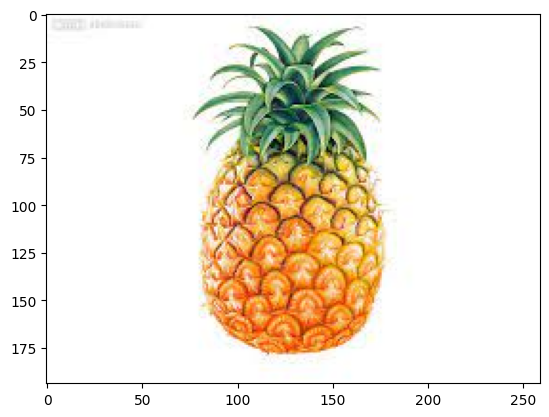

识别结果： 菠萝

In [28]:
from mmpretrain import ImageClassificationInferencer
import cv2
import matplotlib.pyplot as plt


inference = ImageClassificationInferencer('./fruit30/configs/mcls_fruit_resnet50.py','./work_dirs/mcls_fruit_resnet50/epoch_60.pth')
result = inference('./fruit30/configs/pineapple.jpg')
img = cv2.cvtColor(cv2.imread('./fruit30/configs/pineapple.jpg'),cv2.COLOR_BGR2RGB)
plt.imshow(img)

plt.show()
print("识别结果：",result[0]['pred_class'])